# **Use CASCADE to infer spiking activity for your own data**
---

This is a demo script for the inference of spiking activity from calcium imaging data. It is based on the Github repository https://github.com/HelmchenLabSoftware/Cascade. On the repository, you can also find a link to a demo script that runs on the cloud (Colaboratory Notebook) without need to install anything locally.

In this notebook:

The function **load_neurons_x_time()** loads the input data as a matrix. It can
be modified by the user to load npy-files, mat-files or any other standard format.

After loading the dF/F data, some example traces are plotted.
    
The line **spike_rates = cascade.predict( model_name, traces )** performs the
predictions. As input, it uses the loaded calcium recordings ('traces') and
the pretrained model ('model_name'). To train a new model (usually not necessary), check out the companion Jupyter notebook.    
    
The output is a matrix with the inferred spike rates.
    
---

## 1. Import python packages

Imports standard python packages, and the main CASCADE packages (cascade2p).

In [11]:
import os

if 'Demo scripts' in os.getcwd(): os.chdir('..')  # change to main directory
print('Current directory: {}'.format( os.getcwd() ))

import numpy as np
import matplotlib.pyplot as plt
import glob
import scipy.io as sio
import ruamel.yaml as yaml

# local folder
from cascade2p import cascade
from cascade2p.utils import plot_dFF_traces, plot_noise_level_distribution, plot_noise_matched_ground_truth

from cascade2p import checks
checks.check_packages()


Current directory: /home/pierre/Desktop/git_env2/Calibrated-inference-of-spiking
	YAML reader installed (version 0.16.10).
	Keras installed (version 2.1.6).
	Tensorflow installed (version 1.13.1).


## 2. Load your own calcium imaging data

### Define your own function to load data as 2d array (neurons, time)

<font size = 3>The function should return a 2D array (neurons x time) with dF/F values (numeric values, not percent).
    
<font size = 3>Sometimes data are in a different format (time x neurons) or dF/F values are given in percent. In this case, correct by transposing the data (*traces = traces.T*) or by converting from percent to numeric (*traces = traces / 100*).

In [5]:
def load_neurons_x_time(file_path):
    """Custom method to load data as 2d array with shape (neurons, nr_timepoints)"""
    
    # replace this with your own code if necessary
    # traces = np.load(file_path)
    
    # # here numpy dictionary with key 'dff'
    traces = np.load(file_path, allow_pickle=True).item()['dff']
    
    return traces

def load_neurons_x_time(file_path):
    """Custom method to load data as 2d array with shape (neurons, nr_timepoints)"""
    
    traces = sio.loadmat(file_path)['dF_traces'] 
    
    return traces/100

### Verify that the data were loaded correctly

Important: modify folder name (*example_file*) and imaging frame rate (*frame_rate*)!

Number of neurons in dataset: 1005
Number of timepoints in dataset: 260


/home/pierre/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


<IPython.core.display.Javascript object>


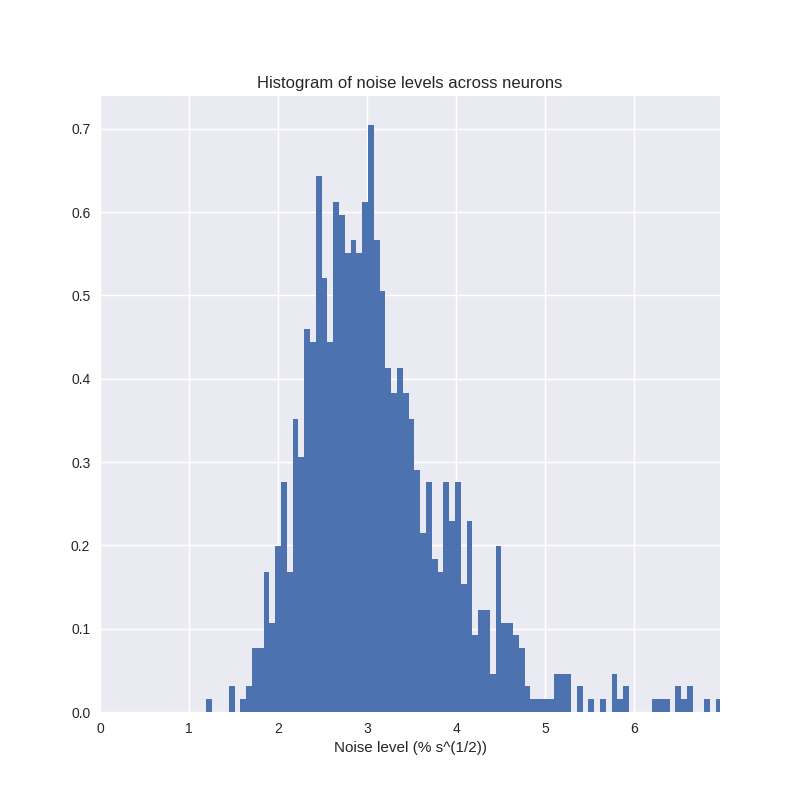

<IPython.core.display.Javascript object>


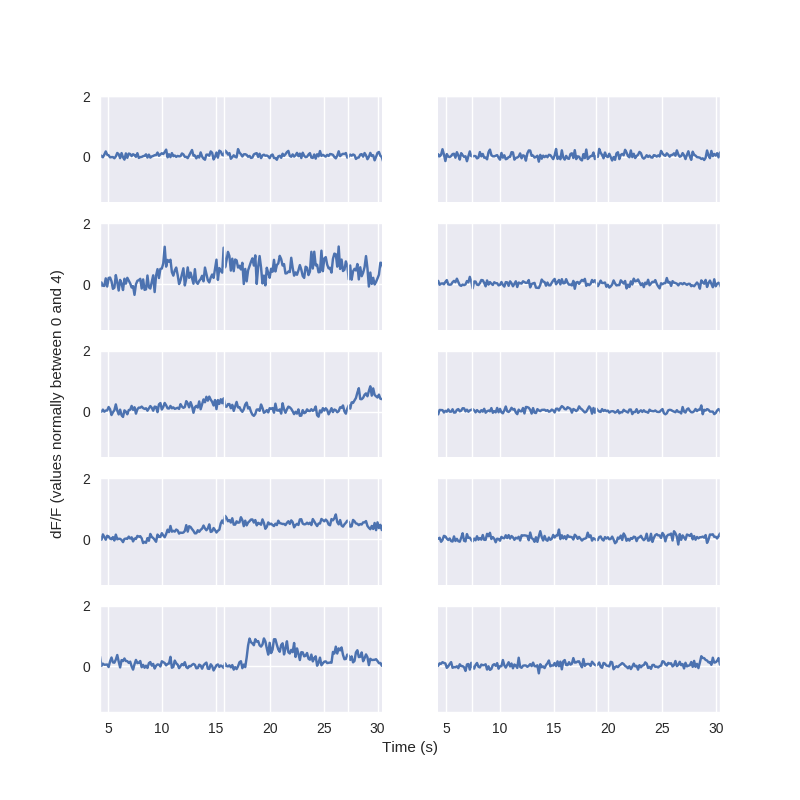

In [6]:
example_file = 'Example_datasets/Multiplane-OGB1-zf-pDp-Rupprecht-7.5Hz/Calcium_traces_04.mat'

traces = load_neurons_x_time( example_file )
frame_rate = 7.5


print('Number of neurons in dataset:', traces.shape[0])
print('Number of timepoints in dataset:', traces.shape[1])

# interactive plotting
%matplotlib notebook

noise_levels = plot_noise_level_distribution(traces,frame_rate)

plt.rcParams['figure.figsize'] = (8.0, 8.0)
neuron_indices = np.random.randint(traces.shape[0], size=10)
plot_dFF_traces(traces,neuron_indices,frame_rate)

## 3. Infer spike rates from calcium data 

### Get list of available models

In [12]:
cascade.download_model( 'update_models',verbose = 1)

yaml_file = open('Pretrained_models/available_models.yaml')
X = yaml.load(yaml_file, Loader=yaml.Loader)
list_of_models = list(X.keys())
print('\n List of available models: \n')
for model in list_of_models:
  print(model)

You can now check the updated available_models.yaml file for valid model names.
File location: /home/pierre/Desktop/git_env2/Calibrated-inference-of-spiking/Pretrained_models/available_models.yaml

 List of available models: 

GCaMP6f_mouse_30Hz_smoothing200ms
OGB_zf_pDp_7.5Hz_smoothing200ms
Universal_5Hz_smoothing200ms
Universal_5Hz_smoothing200ms_causalkernel
Universal_6Hz_smoothing200ms
Universal_6Hz_smoothing200ms_causalkernel
Universal_7.5Hz_smoothing200ms
Universal_7.5Hz_smoothing200ms_causalkernel
Universal_10Hz_smoothing100ms
Universal_10Hz_smoothing100ms_causalkernel
Universal_10Hz_smoothing200ms
Universal_10Hz_smoothing200ms_causalkernel
Universal_12.5Hz_smoothing100ms
Universal_12.5Hz_smoothing100ms_causalkernel
Universal_12.5Hz_smoothing200ms
Universal_12.5Hz_smoothing200ms_causalkernel
Universal_15Hz_smoothing100ms
Universal_15Hz_smoothing100ms_causalkernel
Universal_15Hz_smoothing200ms
Universal_15Hz_smoothing200ms_causalkernel
Universal_17.5Hz_smoothing100ms
Universal_17

### Select and download pretrained model

In [13]:
model_name = 'OGB_zf_pDp_7.5Hz_smoothing200ms'

cascade.download_model( model_name,verbose = 1)

Pretrained model was saved in folder "/home/pierre/Desktop/git_env2/Calibrated-inference-of-spiking/Pretrained_models/OGB_zf_pDp_7.5Hz_smoothing200ms"


### Predict spike rates

In [ ]:
spike_rates = cascade.predict( model_name, traces )

## 4. Save results to a data file

In [7]:
folder = os.path.dirname(traces_file_name)
save_path = os.path.join(folder, 'full_prediction_'+os.path.basename(traces_file_name))

# save as numpy file
np.save(save_path, spike_rates)

# save as .mat file
# import scipy.io as sio
# sio.savemat(save_path, {'spike_rates': spike_rates})

## 5. Plot the results together with calcium traces

<IPython.core.display.Javascript object>


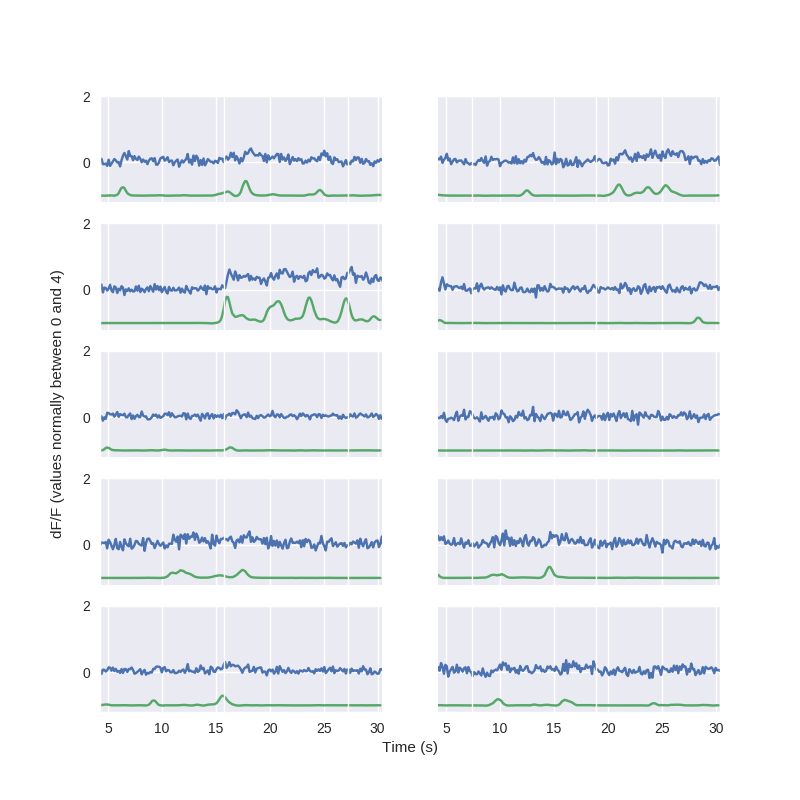

In [19]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)
neuron_indices = np.random.randint(traces.shape[0], size=10)
plot_dFF_traces(traces,neuron_indices,frame_rate,spike_rates)

## 6. Plot noise-matched calcium traces from the ground truth

<IPython.core.display.Javascript object>


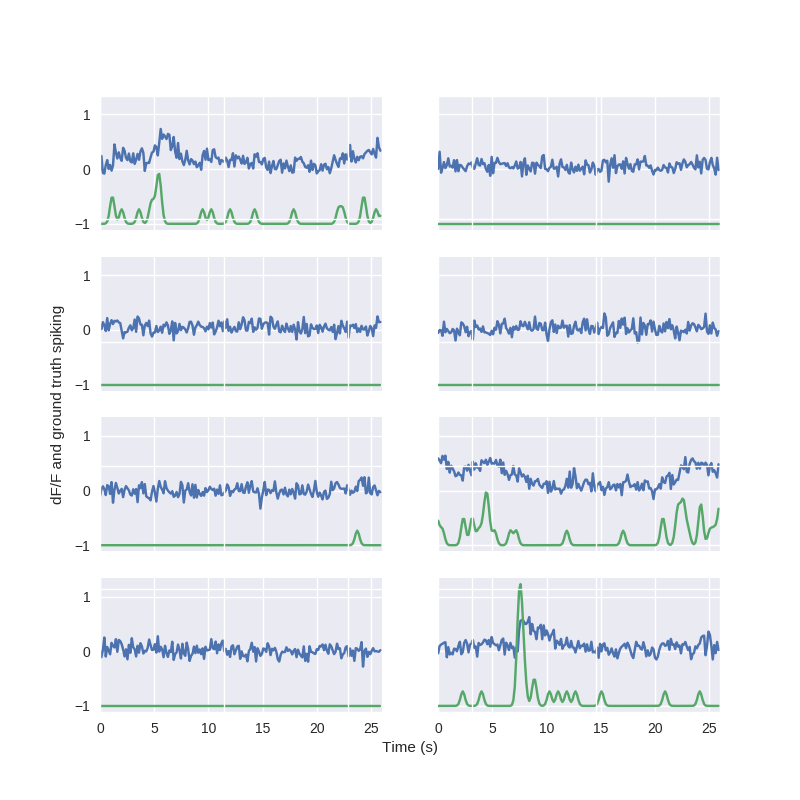

In [18]:
median_noise = np.round(np.median(noise_levels))
nb_traces = 8
duration = 26 # seconds
plot_noise_matched_ground_truth( model_name, median_noise, frame_rate, nb_traces, duration )